In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from math import sqrt
from sympy.ntheory import isprime, quadratic_residues
from scipy.signal import max_len_seq
from perlin_numpy import generate_perlin_noise_2d

plt.rcParams.update({'font.size': 20})

In [5]:
class Mask():

    def __init__(self, sensor_size_px: tuple, 
                 sensor_size_m: tuple, 
                 feature_size: tuple, 
                 distance_sensor: float) -> None:
        
        self.mask = None
        self.sensor_size_px = sensor_size_px
        self.sensor_size_m = sensor_size_m
        self.feature_size = feature_size
        self.distance_sensor = distance_sensor
    
    def shape(self):
        return self.mask.shape



class FlatCam_Mask(Mask):

    def __init__(self, 
                 sensor_size_px: tuple, 
                 sensor_size_m: tuple, 
                 feature_size: tuple, 
                 distance_sensor: float, 
                 method: str, 
                 n_bits: int) -> None:
        
        super().__init__(sensor_size_px, sensor_size_m, feature_size, distance_sensor)
        self.method = method
        self.n_bits = n_bits

        assert method in ['MURA', 'MLS']
        if method == 'MURA':
            self.mask = self.squarepattern(4*n_bits+1)
        else:
            seq = max_len_seq(n_bits)[0] * 2 - 1
            h_r = np.r_[seq, seq]
            self.mask = (np.outer(h_r, h_r) + 1) / 2


    def is_prime(self, n):
        if n % 2 == 0 and n > 2: 
            return False
        return all(n % i for i in range(3, int(sqrt(n)) + 1, 2))
    

    def squarepattern(self, p):
        if not self.is_prime(p):
            raise ValueError("p is not a valid length. It must be prime.")
        A = np.zeros((p, p), dtype=int)
        q = quadratic_residues(p)
        A[1:, 0] = 1
        for j in range(1, p):
            for i in range(1, p):
                if not ((i - 1 in q) != (j - 1 in q)):
                    A[i, j] = 1
        return A



class PhlatCam_Mask(Mask):

    def __init__(self, 
                 sensor_size_px: tuple, 
                 sensor_size_m: tuple, 
                 feature_size: tuple, 
                 distance_sensor: float, 
                 noise_period: tuple) -> None:
        
        super().__init__(sensor_size_px, sensor_size_m, feature_size, distance_sensor)
        self.noise_period = noise_period

        noise = generate_perlin_noise_2d(sensor_size_px, noise_period)
        sqrt_noise = abs(noise) ** 0.5 * np.sign(noise)
        sqrt_noise_as_img = np.interp(sqrt_noise, (-1,1), (0,255)).astype(np.uint8)
        self.mask = cv.Canny(sqrt_noise_as_img,0,255)



class FZA_Mask(Mask):

    def __init__(self, 
                 sensor_size_px: tuple, 
                 sensor_size_m: tuple, 
                 feature_size: tuple, 
                 distance_sensor: float, 
                 radius: tuple) -> None:
        
        super().__init__(sensor_size_px, sensor_size_m, feature_size, distance_sensor)
        self.radius = radius
        self.mask = self.FZA(sensor_size_px, radius)


    def FZA(self, dim, r):
        x, y = np.meshgrid(np.linspace(-dim[0]/2, dim[0]/2-1, dim[0]), np.linspace(-dim[1]/2, dim[1]/2-1, dim[1]))
        mask = 0.5 * (1 + np.cos(np.pi * (x**2 + y**2) / r**2))
        return mask


Mask 1 (MURA 25 bits): shape = (101, 101)
Mask 2 (MLS 5 bits): shape = (62, 62)
Mask 3 (edges): shape = (256, 256)
Mask 4 (FZA): shape = (512, 512)


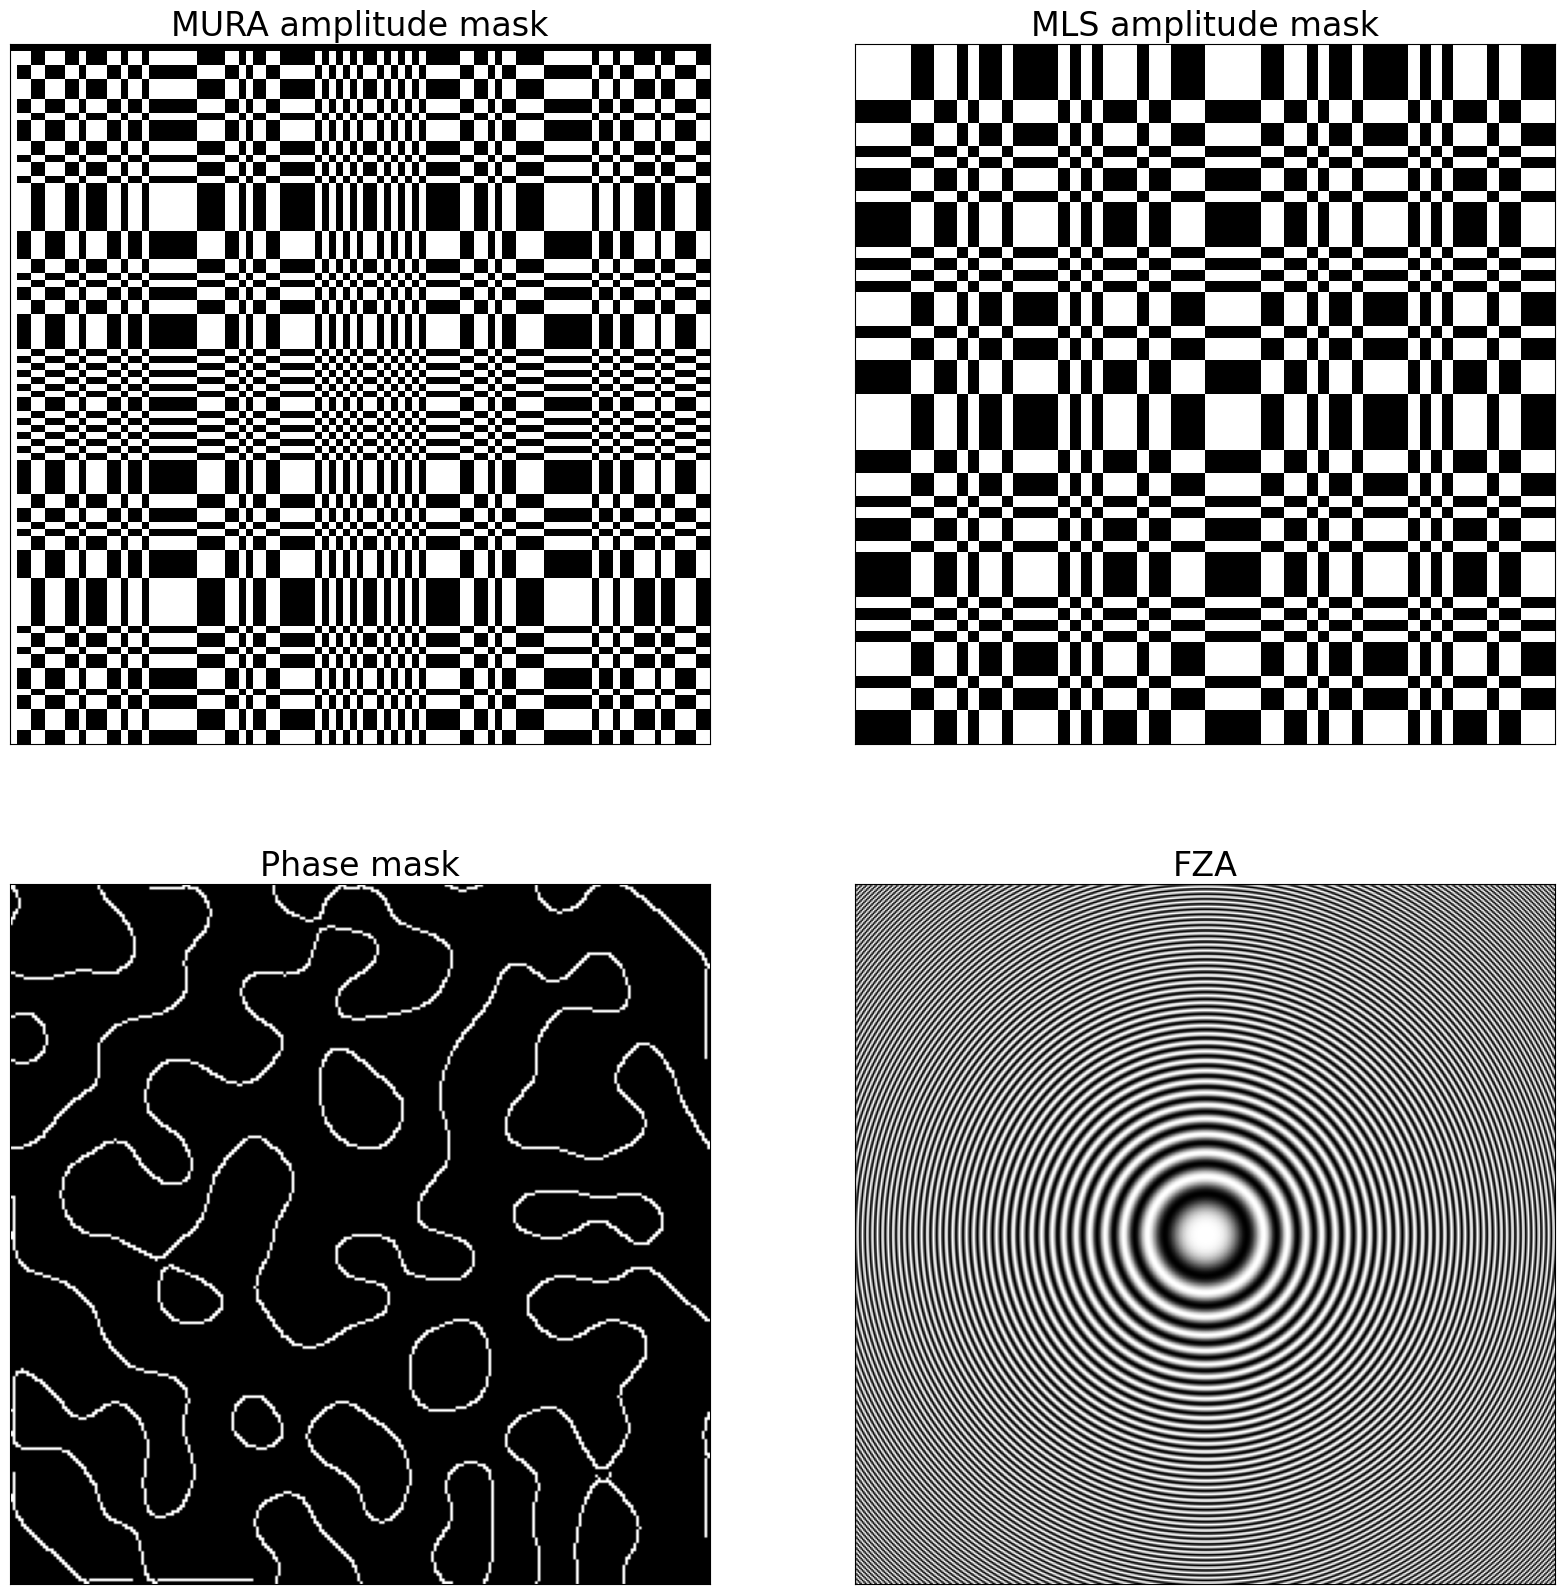

In [7]:
#px_size = 1.55e-06

mask1 = FlatCam_Mask(None, None, None, None, 'MURA', n_bits=25)
print(f'Mask 1 (MURA 25 bits): shape = {mask1.shape()}')
mask2 = FlatCam_Mask(None, None, None, None, 'MLS', n_bits=5)
print(f'Mask 2 (MLS 5 bits): shape = {mask2.shape()}')
mask3 = PhlatCam_Mask((256, 256), None, None, None, (8,8))
print(f'Mask 3 (edges): shape = {mask3.shape()}')
mask4 = FZA_Mask((512, 512), None, None, None, 30)
print(f'Mask 4 (FZA): shape = {mask4.shape()}')

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(mask1.mask, cmap='gray')
plt.title('MURA amplitude mask'), plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(mask2.mask, cmap='gray')
plt.title('MLS amplitude mask'), plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(mask3.mask, cmap='gray')
plt.title('Phase mask'), plt.xticks([]), plt.yticks([])
plt.subplot(224)
plt.imshow(mask4.mask, cmap='gray')
_ = plt.title('FZA'), plt.xticks([]), plt.yticks([])
